In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding",  # this disables constant folding
#     "--xla_cpu_use_thunk_runtime=false",
# )
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+423.g8edac8237.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 9.98 GB available memory.


In [23]:
def set_poincare_equilibrium(eq, ensure_nested=True):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
        ensure_nested=ensure_nested,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [6]:
eq = get("NCSX")

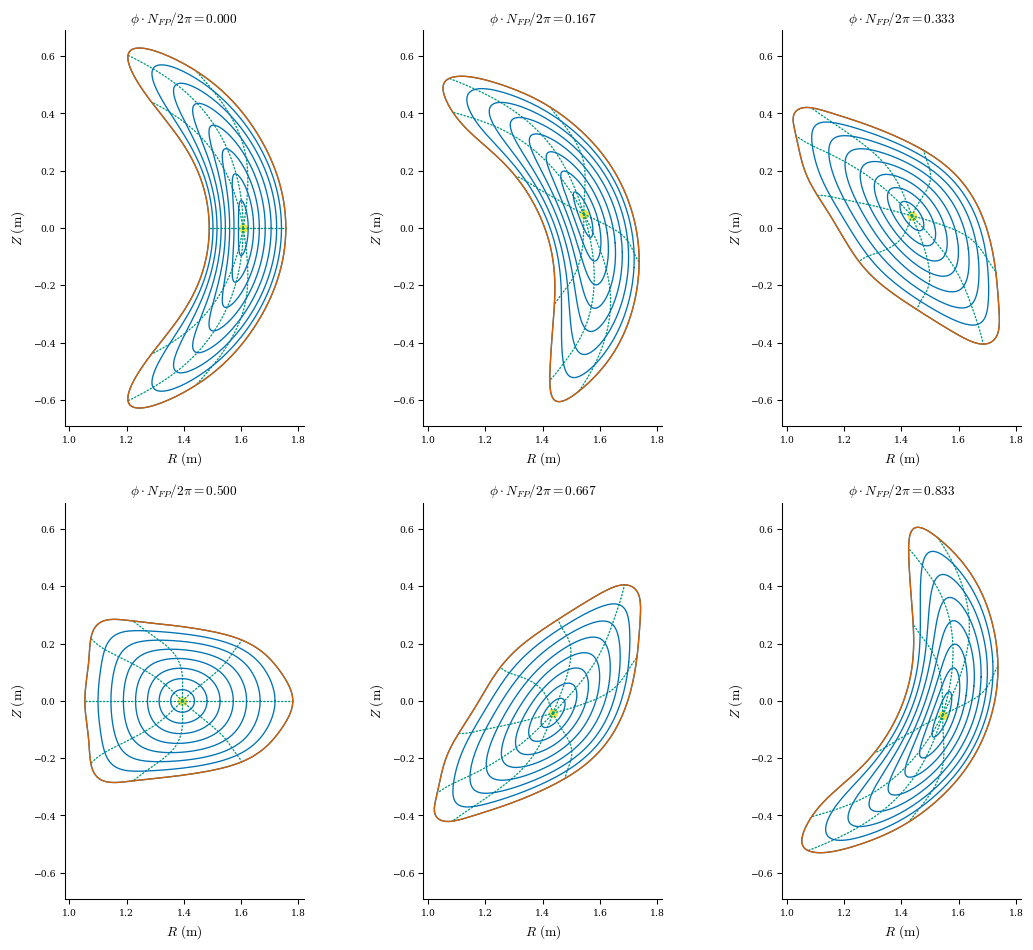

In [8]:
plot_surfaces(eq);

# Zernike Coeffcients for Poincare Cross-section can create self-intersecting surfaces!

We will change the high mode coefficients to a relatively large value to create self-intersection.

In [19]:
eq1 = eq.copy()
print(eq1.R_lmn[eq.R_basis.modes[:, 0] == 10])
eq1.R_lmn[eq.R_basis.modes[:, 0] == 10] = 0.01

[-0.     -0.      0.      0.     -0.      0.      0.      0.     -0.      0.      0.0001 -0.     -0.      0.     -0.      0.0003 -0.     -0.      0.     -0.      0.0005 -0.0001 -0.     -0.      0.      0.0006 -0.0002  0.     -0.     -0.     -0.0002 -0.0002 -0.0001  0.0001  0.0003  0.      0.0001  0.      0.0001 -0.0002  0.0001  0.0002  0.0001 -0.     -0.      0.      0.      0.      0.     -0.0001 -0.      0.0001 -0.0001 -0.0002  0.     -0.0001  0.0001  0.     -0.      0.     -0.      0.      0.0002 -0.0005  0.     -0.0001 -0.      0.      0.0001 -0.0006  0.     -0.      0.      0.      0.0001 -0.0002 -0.     -0.     -0.      0.      0.     -0.0001 -0.      0.      0.      0.     -0.     -0.      0.      0.     -0.     -0.      0.      0.    ]


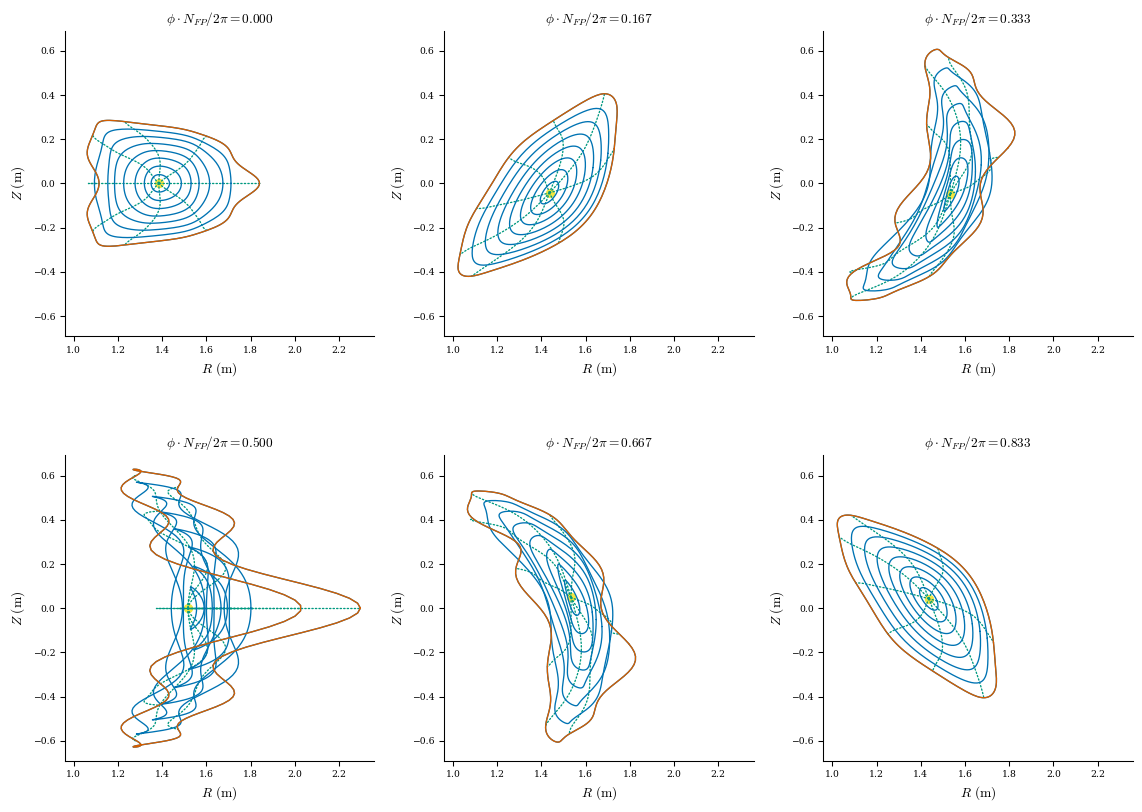

In [26]:
eq1_rotated = rotate_zeta(eq1, angle=np.pi / eq.NFP, copy=True)
plot_surfaces(eq1_rotated);

Nothing is limiting the self-intersection of surfaces when you use Poincare representation.

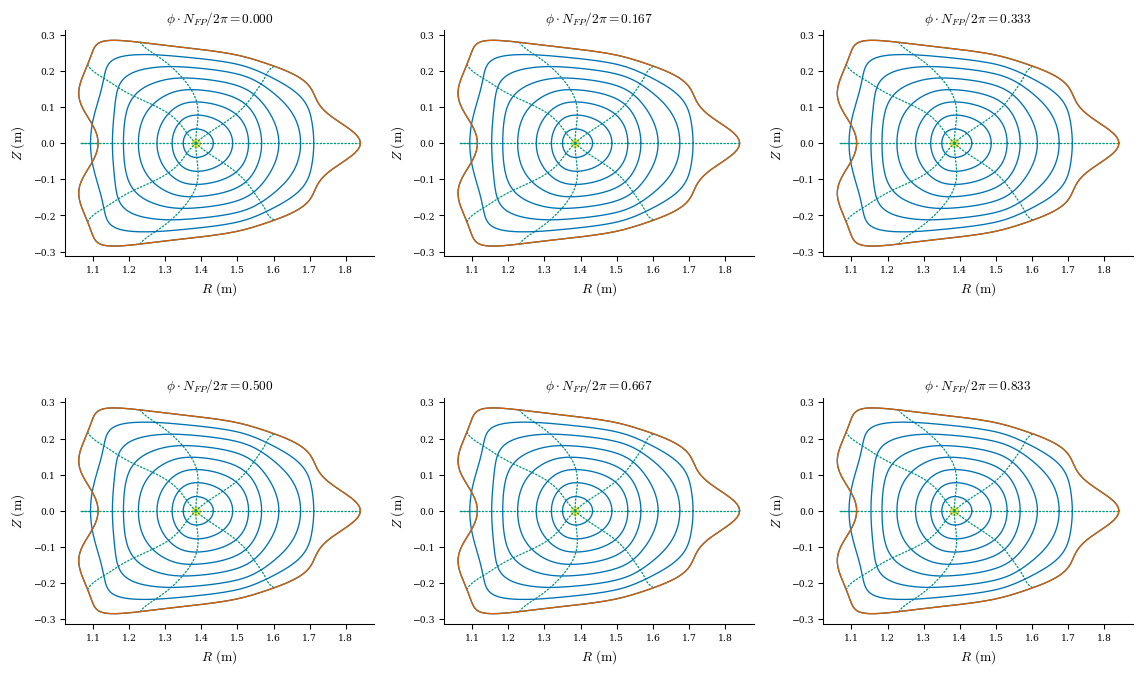

In [27]:
eq1p = set_poincare_equilibrium(eq1_rotated, ensure_nested=False)
plot_surfaces(eq1p);

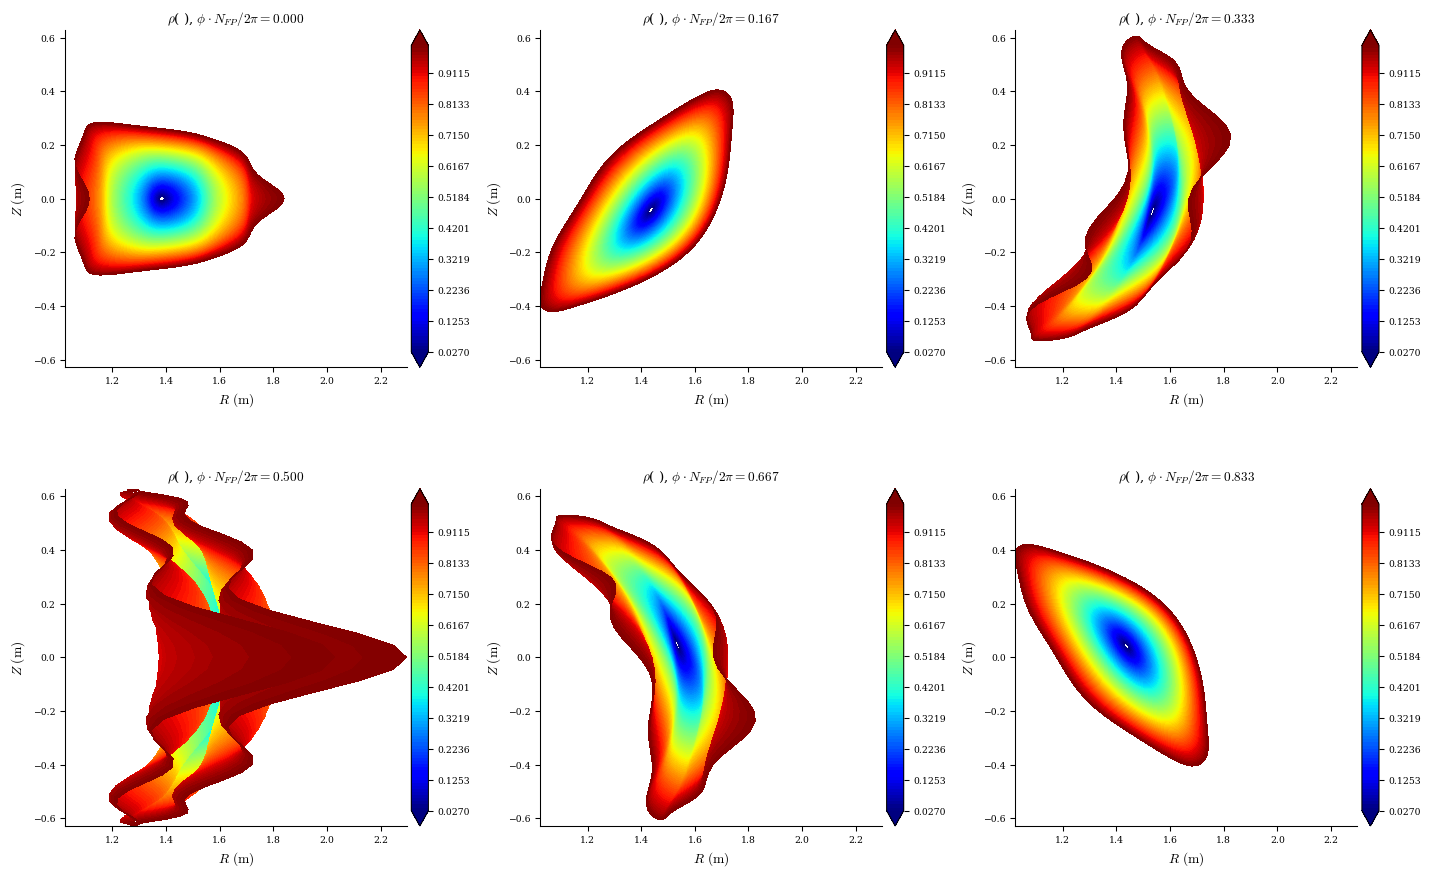

In [29]:
plot_section(eq1_rotated, "rho");

# Closeness in phase-space